In [118]:
######## MODULES ##########
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celia_functions as cf
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
pd.set_option('display.max_rows', 50)
#np.set_printoptions(threshold=sys.maxsize)

pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

In [119]:
shotsheet = cf.read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel","Thickness (um)","Length(mm)","Material","Type"])

shotsheet = pd.DataFrame(shotsheet)
targetsheet = pd.DataFrame(targetsheet)

to_numeric = lambda series: pd.to_numeric(series, errors= "coerce") # pd.to_numeric works on pd.series but not on pd.DataFrames
shotsheet = shotsheet.apply(to_numeric) 
shotsheet.dropna(how= "all", inplace= True) # last row has no data! Remove it.

shotsheet = shotsheet.merge(targetsheet, how= "left", left_on= "TARGET NUMBER", right_on= "Number") # merge the targetsheet with the shotsheet

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm)
count,266.000000,234.000000,234.000000,266.000000,201.000000,266.000000,266.000000,266.000000,266.000000
mean,132.661654,3.552863,6.181303,68.000000,0.884909,68.000000,4.409774,264.097744,8.300752
std,76.697139,1.382375,0.950730,37.500893,0.173772,37.500893,1.806001,397.911451,1.228498
min,1.000000,0.705000,3.195000,1.000000,0.091800,1.000000,1.000000,25.000000,4.000000
25%,66.250000,2.475000,5.590000,33.750000,0.827000,33.750000,3.000000,50.000000,8.000000
50%,132.500000,3.395000,6.170000,69.000000,0.873000,69.000000,4.000000,50.000000,8.000000
75%,198.750000,4.511250,6.790000,104.750000,0.953000,104.750000,6.000000,50.000000,8.000000
max,265.000000,6.985000,8.815000,125.000000,1.800000,125.000000,7.000000,1000.000000,10.000000


In [120]:
shotsheet["relative X"] = shotsheet.groupby('Number')['Target X'].transform(lambda x: x -x.iloc[0]) #calculate the relitive movement from the first shot.
shotsheet["relative Z"] = shotsheet.groupby('Number')['Target Z'].transform(lambda x: x -x.iloc[0])
shotsheet["nth shot on target"] = shotsheet.groupby('Number')["Number"].transform(lambda series: np.arange(len(series)) +1) #add a column that counts how many times the target has been shot.

shotsheet["d"] = np.linalg.norm(shotsheet[["relative X", "relative Z"]], axis= 1) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

# Apply filters
shotsheet = shotsheet[shotsheet["Type"] == "wire"]
shotsheet = shotsheet[shotsheet["Material"] == "Cu"]
shotsheet = shotsheet[shotsheet["Length(mm)"] == 8]
shotsheet = shotsheet[shotsheet["nth shot on target"] == 8]

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d
count,7.000000,6.000000,6.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.0,6.000000,6.000000,7.0,6.000000
mean,140.142857,4.584167,6.725833,75.571429,0.802286,75.571429,4.571429,50.0,8.0,2.596667,1.485000,8.0,3.022092
std,56.989556,0.959856,0.444651,22.838981,0.090814,22.838981,0.975900,0.0,0.0,0.739775,0.116705,0.0,0.581996
min,83.000000,2.965000,6.125000,58.000000,0.644000,58.000000,4.000000,50.0,8.0,1.180000,1.310000,8.0,1.948050
25%,102.000000,4.147500,6.451250,59.500000,0.760500,59.500000,4.000000,50.0,8.0,2.550000,1.416250,8.0,2.954939
50%,121.000000,4.890000,6.780000,66.000000,0.844000,66.000000,4.000000,50.0,8.0,2.800000,1.517500,8.0,3.108330
75%,169.500000,5.268750,6.895000,88.500000,0.858000,88.500000,5.000000,50.0,8.0,3.050000,1.543750,8.0,3.381690
max,234.000000,5.465000,7.395000,109.000000,0.891000,109.000000,6.000000,50.0,8.0,3.200000,1.630000,8.0,3.591225


### Choose which targets and channels to use here!

In [121]:
pyro_background = {"Ch1": [99,100,101,102,104,105,107,108,109,110,111,112,113,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,214,215,216,217,218,219,220,221,222,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
                   "Ch2": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140141,142,143,144,145,146,147,148,149,150,151,152,153],
                   "Ch3": [70,71,72,74,75,76,77,78,79,80,83,84,85,86,87,88,89,92,93,94,95,96,97,98]}

diagnostics = {"Ch1": shotsheet["SHOT #"],
               "Ch2": shotsheet["SHOT #"],
               "Ch3": shotsheet["SHOT #"],
               "Ch4": shotsheet["SHOT #"],
               "bdot": shotsheet["SHOT #"],
               "xray": shotsheet["SHOT #"],
               "energy": shotsheet["SHOT #"]}

diagnostics_functions = {"Ch1": lambda x: x,
                         "Ch2": lambda x: x,
                         "Ch3": lambda x: x,
                         "Ch4": lambda x: x,
                         "bdot": lambda x: np.ma.masked_invalid(x).ptp(),
                         "tof": np.ptp,
                         "diode": np.ptp,
                         "xray": cf.estimate_xray_signal,
                         "energy": lambda x: x}

diagnostic_data = cf.read_diagnostic_data(diagnostics, functions= diagnostics_functions, silent= False)
diagnostic_data = pd.DataFrame(diagnostic_data)

background_lookup = pd.DataFrame(([shot, ch, cf.flatten_list(diagnostic_data[ch][diagnostic_data["shot"] == shot].values)] for ch, shots in pyro_background.items() for shot in shots), columns= ["shot", "bg channel", "bg data"]) #Create a dataframe with the bg data


Found 6 files:
   290124WIRESHOT83000_Ch1.csv
   290124WIRESHOT98000_Ch1.csv
   290124WIRESHOT135000_Ch1.csv
   290124WIRESHOT121000_Ch1.csv
   290124WIRESHOT204000_Ch1.csv
   290124WIRESHOT234000_Ch1.csv
Found 6 files:
   290124WIRESHOT83000_Ch2.csv
   290124WIRESHOT98000_Ch2.csv
   290124WIRESHOT135000_Ch2.csv
   290124WIRESHOT121000_Ch2.csv
   290124WIRESHOT204000_Ch2.csv
   290124WIRESHOT234000_Ch2.csv
Found 6 files:
   290124WIRESHOT83000_Ch3.csv
   290124WIRESHOT98000_Ch3.csv
   290124WIRESHOT135000_Ch3.csv
   290124WIRESHOT121000_Ch3.csv
   290124WIRESHOT204000_Ch3.csv
   290124WIRESHOT234000_Ch3.csv
Found 6 files:
   290124WIRESHOT83000_Ch4.csv
   290124WIRESHOT98000_Ch4.csv
   290124WIRESHOT135000_Ch4.csv
   290124WIRESHOT121000_Ch4.csv
   290124WIRESHOT204000_Ch4.csv
   290124WIRESHOT234000_Ch4.csv
Found 4 files:
   s83_ALL.csv
   s98_ALL.csv
   s106_ALL.csv
   S135_ALL.csv
Found 6 files:
   2024 janvier 29 17_25_54 SHOT83.tif
   2024 janvier 29 19_17_58 SHOT98.tif
   2024 ja

In [122]:
active_pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys())) # useful to know which pyro channels to analysise and plot

diagnostic_data = diagnostic_data.merge(background_lookup, how= "left", on= "shot") # add the background infomation to the shotsheet
diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured

diagnostic_data[active_pyro_channels] = (diagnostic_data[active_pyro_channels].values.T -diagnostic_data["bg data"].values).T # Background subtraction. It took me ages to figure out how to do this with pandas. (Spoilers: I cheated and converted it into numpy arrays)
diagnostic_data.drop("bg data", axis= 1, inplace= True) # The background data is no longer needed now that we have finished background subtraction.

diagnostic_data.describe()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_23184\2145891751.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured


,shot,bdot,xray,energy
count,7.000000,4.000000,6.000000,5.000000e+00
mean,140.142857,0.615105,583.416667,9.846000e-07
std,56.989556,0.152748,378.221948,4.510818e-07
min,83.000000,0.446766,197.000000,5.770000e-07
25%,102.000000,0.511453,242.500000,6.500000e-07
50%,121.000000,0.615570,550.000000,7.660000e-07
75%,169.500000,0.719223,920.500000,1.350000e-06
max,234.000000,0.782516,1019.500000,1.580000e-06


In [123]:
find_minima = lambda x: np.abs(np.nanmin(x))
diagnostic_data[active_pyro_channels] = diagnostic_data[active_pyro_channels].map(find_minima, na_action= "ignore") # find the minima of every pyro channel. df.map applies the function element-wise rather than row or column-wise

shotsheet = shotsheet.merge(diagnostic_data, how= "left", left_on= "SHOT #", right_on= "shot") #merge with shotsheet

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,...,nth shot on target,d,shot,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy
count,7.000000,6.000000,6.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.0,6.000000,...,7.0,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,4.000000,6.000000,5.000000e+00
mean,140.142857,4.584167,6.725833,75.571429,0.802286,75.571429,4.571429,50.0,8.0,2.596667,...,8.0,3.022092,140.142857,0.106667,0.232000,1.003333,0.764000,0.615105,583.416667,9.846000e-07
std,56.989556,0.959856,0.444651,22.838981,0.090814,22.838981,0.975900,0.0,0.0,0.739775,...,0.0,0.581996,56.989556,0.117239,0.203332,1.303437,0.289363,0.152748,378.221948,4.510818e-07
min,83.000000,2.965000,6.125000,58.000000,0.644000,58.000000,4.000000,50.0,8.0,1.180000,...,8.0,1.948050,83.000000,0.000000,0.000000,0.000000,0.432000,0.446766,197.000000,5.770000e-07
25%,102.000000,4.147500,6.451250,59.500000,0.760500,59.500000,4.000000,50.0,8.0,2.550000,...,8.0,2.954939,102.000000,0.010000,0.048000,0.070000,0.528000,0.511453,242.500000,6.500000e-07
50%,121.000000,4.890000,6.780000,66.000000,0.844000,66.000000,4.000000,50.0,8.0,2.800000,...,8.0,3.108330,121.000000,0.070000,0.256000,0.360000,0.756000,0.615570,550.000000,7.660000e-07
75%,169.500000,5.268750,6.895000,88.500000,0.858000,88.500000,5.000000,50.0,8.0,3.050000,...,8.0,3.381690,169.500000,0.202000,0.380000,1.850000,0.984000,0.719223,920.500000,1.350000e-06
max,234.000000,5.465000,7.395000,109.000000,0.891000,109.000000,6.000000,50.0,8.0,3.200000,...,8.0,3.591225,234.000000,0.264000,0.480000,2.980000,1.128000,0.782516,1019.500000,1.580000e-06


In [124]:
diags = list(diagnostics)

shotsheet[diags] = (shotsheet[diags].values.T /shotsheet["Laser Energy (before comp) [J]"].values).T # normalise for laser energy
#shotsheet[diags] = shotsheet.groupby('TARGET NUMBER')[diags].transform(lambda x: x /x.iloc[0]) # normalise to first shot on target
#shotsheet[diags] = shotsheet[diags] /shotsheet[diags].mean()
shotsheet = shotsheet.replace([-np.inf, np.inf], np.nan) # infs are invalid. I think there were some div 0 errors when normalising to the first shot on target.

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,...,nth shot on target,d,shot,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy
count,7.000000,6.000000,6.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.0,6.000000,...,7.0,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,4.000000,6.000000,5.000000e+00
mean,140.142857,4.584167,6.725833,75.571429,0.802286,75.571429,4.571429,50.0,8.0,2.596667,...,8.0,3.022092,140.142857,0.132166,0.280791,1.368489,0.984239,0.795508,750.287854,1.292679e-06
std,56.989556,0.959856,0.444651,22.838981,0.090814,22.838981,0.975900,0.0,0.0,0.739775,...,0.0,0.581996,56.989556,0.138033,0.241210,1.773466,0.396059,0.305446,547.895072,6.442810e-07
min,83.000000,2.965000,6.125000,58.000000,0.644000,58.000000,4.000000,50.0,8.0,1.180000,...,8.0,1.948050,83.000000,0.000000,0.000000,0.000000,0.484848,0.518892,233.412322,6.701510e-07
25%,102.000000,4.147500,6.451250,59.500000,0.760500,59.500000,4.000000,50.0,8.0,2.550000,...,8.0,2.954939,102.000000,0.012330,0.056872,0.078563,0.659135,0.603374,282.390937,7.701422e-07
50%,121.000000,4.890000,6.780000,66.000000,0.844000,66.000000,4.000000,50.0,8.0,2.800000,...,8.0,3.108330,121.000000,0.102301,0.339096,0.466986,1.043990,0.724028,625.884577,1.078873e-06
75%,169.500000,5.268750,6.895000,88.500000,0.858000,88.500000,5.000000,50.0,8.0,3.050000,...,8.0,3.381690,169.500000,0.248536,0.463553,2.856793,1.300201,0.916162,1149.327049,1.847953e-06
max,234.000000,5.465000,7.395000,109.000000,0.891000,109.000000,6.000000,50.0,8.0,3.200000,...,8.0,3.591225,234.000000,0.308772,0.538720,3.674476,1.416149,1.215086,1524.844720,2.096273e-06


### Setup parameters for graph

In [125]:
### best fit parameters
number_of_points = 100 #number of points for the best fit line.
confidence= 0.05 #only used by polynomial_fit

x0 = {"Ch1": [1,1e5],
      "Ch2": [1,1e5],
      "Ch3": [1,1e5],
      "Ch4": [1,1e5],
      "bdot": [1,1e5],
      "energy": [1e-6,1],
      "xray": [0,1e6]}

constraints = {"Ch1": None, #[[lower], [upper]]
               "Ch2": None,
               "Ch3": None,
               "Ch4": None,
               "bdot": None, #scipy least_squares doesn't support equality constraints for some reason.
               "energy": None,
               "xray": None}

formatting = {"Ch1": {"colour": "aquamarine", "linestyle": "-", "marker": "^"},
              "Ch2": {"colour": "cyan", "linestyle": "-", "marker": ">"},
              "Ch3": {"colour": "dodgerblue", "linestyle": "-", "marker": "v"},
              "Ch4": {"colour": "blue", "linestyle": "-", "marker": "<"},
              "bdot": {"colour": "crimson", "linestyle": "-.", "marker": "s"},
              "energy": {"colour": "black", "linestyle": "--", "marker": "o"},
              "xray": {"colour": "darkgreen", "linestyle": ":", "marker": "x"}}

xaxis = "SHOT #"

model= cf.polynomial

In [126]:
scatter_points = pd.DataFrame(columns= [*diagnostics, "d"])
scatter_error = pd.DataFrame(columns= [*diagnostics, "d"])

scatter_points = shotsheet.groupby('nth shot on target')[[*diagnostics, "d"]].mean()
scatter_error = shotsheet.groupby('nth shot on target')[[*diagnostics, "d"]].std()

def binned_mean(y, x, function):
    means = []
    bins = np.linspace(x.min(), x.max(), 8, endpoint= True)
    for bin_min, bin_max in zip(bins[:-1], bins[1:]):
        mean = y[np.logical_and(bin_min <= x, x <= bin_max)]
        mean = function(mean)
        means = means + [mean]
    return means

#scatter_points = shotsheet[[*diagnostics, "d"]].apply(binned_mean, x= shotsheet["d"], function= np.mean) # df.apply is very fussy. be careful which function to use with it.
#scatter_error = shotsheet[[*diagnostics, "d"]].apply(binned_mean, x= shotsheet["d"], function= np.std)

scatter_points

,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy,d
nth shot on target,,,,,,,,
8,0.132166,0.280791,1.368489,0.984239,0.795508,750.287854,0.000001,3.022092


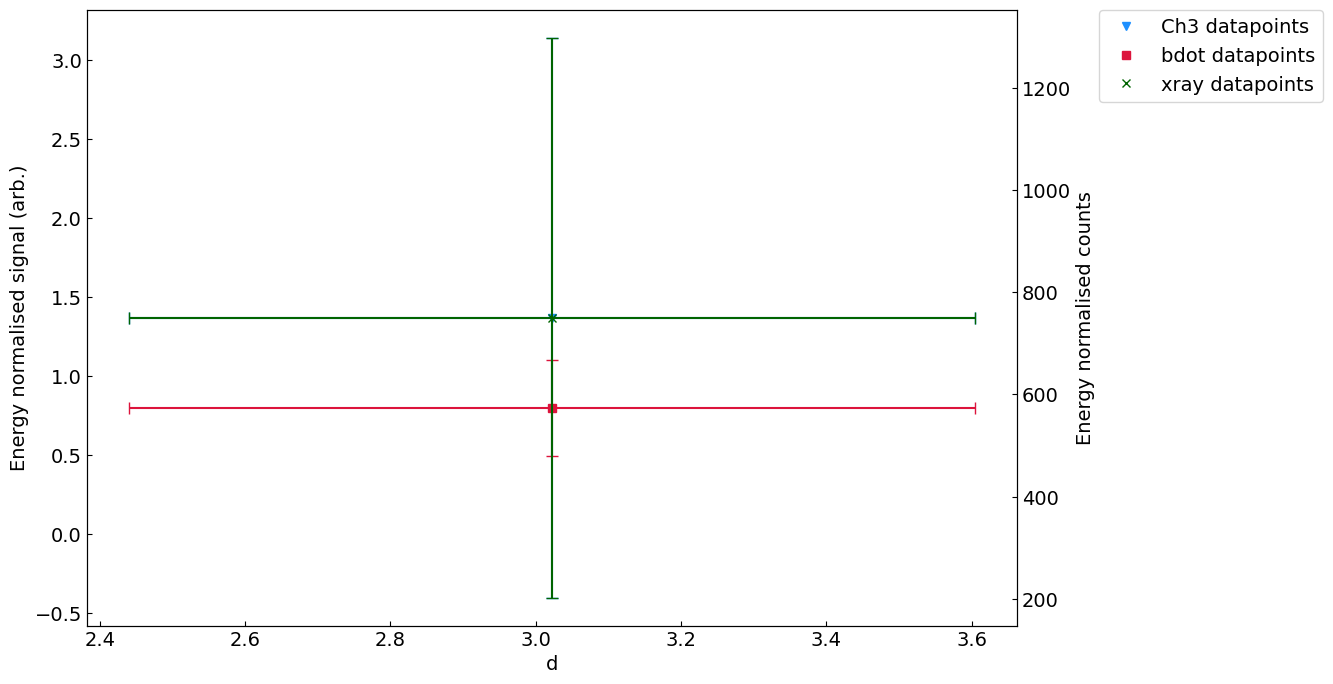

In [127]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))
handles = {}

def plot_diagnostic(diagnostic, ax):
    ax.errorbar(scatter_points["d"],
                        scatter_points[diagnostic],
                        xerr= scatter_error["d"],
                        yerr= scatter_error[diagnostic],
                        color= formatting[diagnostic]["colour"],
                        linestyle= "None",
                        capsize= 4,
                        marker= formatting[diagnostic]["marker"],
                        label= "{0:} datapoints".format(diagnostic))

for diagnostic in ["Ch3","bdot"]:
    plot_diagnostic(diagnostic, axs)

twinax = axs.twinx() 
for diagnostic in ["xray"]:
    plot_diagnostic(diagnostic, twinax)

handles, labels = zip(axs.get_legend_handles_labels(), twinax.get_legend_handles_labels())

axs.set(xlabel= "d",
        ylabel= "Energy normalised signal (arb.)")
twinax.set(ylabel= "Energy normalised counts")

handles = cf.flatten_list(handles)[::7]
labels = cf.flatten_list(labels)
axs.legend(handles, labels, loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_23184\183681163.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(xticks)


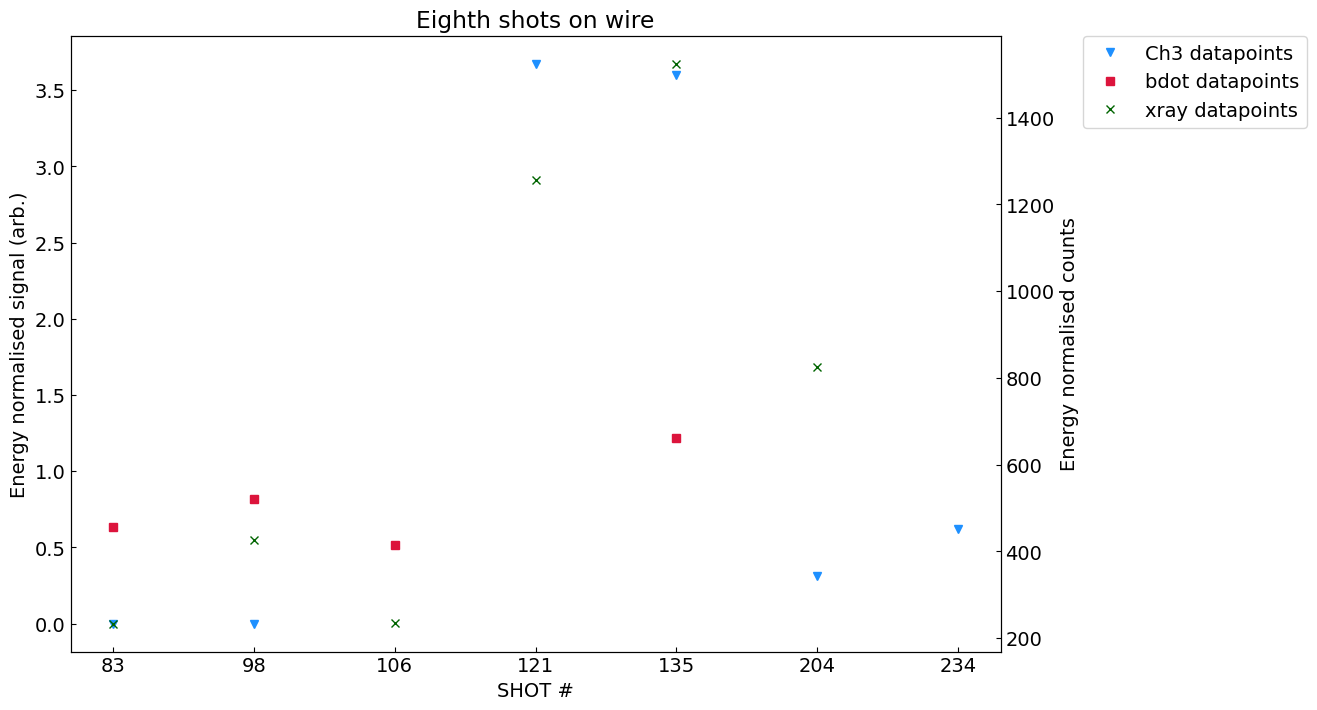

In [129]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))
handles = {}

def plot_diagnostic(diagnostic, ax):
    ax.plot(shotsheet[xaxis].astype(int).astype(str),
            shotsheet[diagnostic],
            color= formatting[diagnostic]["colour"],
            linestyle= "None",
            marker= formatting[diagnostic]["marker"],
            label= "{0:} datapoints".format(diagnostic))

for diagnostic in ["Ch3","bdot"]:
    plot_diagnostic(diagnostic, axs)

twinax = axs.twinx() 
for diagnostic in ["xray"]:
    plot_diagnostic(diagnostic, twinax)

handles, labels = zip(axs.get_legend_handles_labels(), twinax.get_legend_handles_labels())

axs.set(xlabel= xaxis,
        ylabel= "Energy normalised signal (arb.)",
        title= "Eighth shots on wire")
twinax.set(ylabel= "Energy normalised counts")

fig.canvas.draw()
xticks = np.array([item.get_text() for item in axs.get_xticklabels()])
#xticks[::2] = ""
axs.set_xticklabels(xticks)

handles = cf.flatten_list(handles)
labels = cf.flatten_list(labels)
axs.legend(handles, labels, loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()